In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/beegfs/scratch_copy/ahringer/jj374/lab/relmapping


In [2]:
# Build gdf
def addon_H3K36me3_gene(df_regl_arg):
    random.seed(1)
    def H3K36me3_gene_id_(prom_fwd_gene_id, prom_rev_gene_id, associated_gene_id):
        if prom_fwd_gene_id != '.' and prom_rev_gene_id != '.':
            return random.choice([prom_fwd_gene_id, prom_rev_gene_id])
        elif prom_fwd_gene_id != '.':
            return prom_fwd_gene_id
        elif prom_rev_gene_id != '.':
            return prom_rev_gene_id
        else:
            return random.choice(associated_gene_id.split(','))

    df_regl_ = df_regl_arg.copy()
    df_regl_['H3K36me3_gene_id'] = list(map(H3K36me3_gene_id_, 
                                           df_regl_arg['promoter_gene_id_fwd'],
                                           df_regl_arg['promoter_gene_id_rev'],
                                           df_regl_arg['associated_gene_id']))

    col_ = ['chrom', 'start', 'end', 'strand', 'gene_id']
    df_genes = pd.read_csv('WS260_ce10/WS260_ce10.genes_by_CV.tsv', sep='\t')[col_]\
        .drop_duplicates(subset=['gene_id']) # CV table has two duplicate gene records where a gene is annotated in *two* distinct operons

    df_genes.columns = [
        'H3K36me3_gene_chrom',
        'H3K36me3_gene_start',
        'H3K36me3_gene_end',
        'H3K36me3_gene_strand',
        'H3K36me3_gene_id',
    ]

    df_regl = df_regl_.merge(df_genes, how='left', left_on='H3K36me3_gene_id', right_on='H3K36me3_gene_id')
    m_ = ~(df_regl['H3K36me3_gene_strand'] == '-')
    df_regl['H3K36me3_gene_start'] -= 1
    df_regl.loc[m_, 'H3K36me3_gene_end'] = df_regl.loc[m_, 'H3K36me3_gene_start'] + 1
    df_regl.loc[~m_, 'H3K36me3_gene_start'] = df_regl.loc[~m_, 'H3K36me3_gene_end'] - 1
    return df_regl

df_regl = regl_Apr27()
addon_H3K4me3(df_regl)
addon_H3K27me3(df_regl)
df_regl_H3K36me3 = addon_H3K36me3_gene(df_regl)
gdf = yp.GenomicDataFrame(df_regl_H3K36me3, pos_column='atac_mode')

df_regl.query('annot == "coding_promoter"')[[
    'H3K27me3_mean_mean',
    'H3K27me3_mean_max',
    'H3K27me3_max_mean',
    'H3K27me3_max_max',
    'CV'
]].corr(method='spearman')

df_regl.query('annot == "coding_promoter"')[[
    'H3K4me3_mean_mean',
    'H3K4me3_mean_max',
    'H3K4me3_max_mean',
    'H3K4me3_max_max',
    'CV'
]].corr(method='spearman')

df_regl.query('annot == "putative_enhancer"')[[
    'H3K27me3_mean_mean',
    'H3K27me3_mean_max',
    'H3K27me3_max_mean',
    'H3K27me3_max_max',
    'CV'
]].corr(method='spearman')

df_regl.query('annot == "putative_enhancer"')[[
    'H3K4me3_mean_mean',
    'H3K4me3_mean_max',
    'H3K4me3_max_mean',
    'H3K4me3_max_max',
    'CV'
]].corr(method='spearman')

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice


13054 of 42245 sites with CV values via promoter annotation
26764 of 42245 sites with CV values via "associated gene"
H3K4me3 wt_emb True


/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: All-NaN slice encountered
  


H3K4me3 wt_l1 True
H3K4me3 wt_l2 True
H3K4me3 wt_l3 True
H3K4me3 wt_l4 True
H3K4me3 wt_ya True
H3K27me3 wt_emb True
H3K27me3 wt_l1 True
H3K27me3 wt_l2 True
H3K27me3 wt_l3 True
H3K27me3 wt_l4 True
H3K27me3 wt_ya True
gdf: pos_column unspecified, reverting to mean(start, end)


,H3K4me3_mean_mean,H3K4me3_mean_max,H3K4me3_max_mean,H3K4me3_max_max,CV
H3K4me3_mean_mean,1.000000,0.915260,0.977836,0.897353,-0.143918
H3K4me3_mean_max,0.915260,1.000000,0.891044,0.966030,-0.144604
H3K4me3_max_mean,0.977836,0.891044,1.000000,0.916869,-0.136020
H3K4me3_max_max,0.897353,0.966030,0.916869,1.000000,-0.137770
CV,-0.143918,-0.144604,-0.136020,-0.137770,1.000000


In [4]:
# Histone marks -- read signal

# H3K4me3, H3K4me1 at sites
for hmod in ['H3K4me3', 'H3K4me1']:
    for stage in config['stages_wt']:
        fp_ = 'hmod_geo/tracks/%s_%s.bw' % (hmod, stage)
        label = '%s\n%s' % (hmod, stage)
        gdf.add_track(label, fp_, flank_len=1000, bin_size=25)

# H3K27me3 at sites
for hmod in ['H3K27me3']:
    for stage in config['stages_wt']:
        fp_ = 'hmod_geo/tracks/%s_%s.bw' % (hmod, stage)
        label = '%s\n%s' % (hmod, stage)
        gdf.add_track(label, fp_, flank_len=1000, bin_size=25)

mread_regions True H3K4me3_wt_emb.bw.mread_regions_68c5afb1864752a35288eb157782bed4.tmp
mread_regions True H3K4me3_wt_l1.bw.mread_regions_8567b9aeb08e90642dab74a5dc648e3c.tmp
mread_regions True H3K4me3_wt_l2.bw.mread_regions_c49e8b0e1acd9ea9daa2b7850cad9a43.tmp
mread_regions True H3K4me3_wt_l3.bw.mread_regions_3cb99fdb8d17774374ac60f8326cd832.tmp
mread_regions True H3K4me3_wt_l4.bw.mread_regions_fcf080c44808fa792e7cf174e002dbe7.tmp
mread_regions True H3K4me3_wt_ya.bw.mread_regions_26b4f576ef8ceb5542ec3b4c3851a4fc.tmp
mread_regions True H3K4me1_wt_emb.bw.mread_regions_3ffc6c69b9acd6eba368435b24044c95.tmp
mread_regions True H3K4me1_wt_l1.bw.mread_regions_098d4c9b55c4647d7e0b9b6c8908d8bd.tmp
mread_regions True H3K4me1_wt_l2.bw.mread_regions_511bb68fb19fe5f1d9090deaf47def49.tmp
mread_regions True H3K4me1_wt_l3.bw.mread_regions_8fa365b13c0a4ac33bb64823bcda77bb.tmp
mread_regions True H3K4me1_wt_l4.bw.mread_regions_fa5b7c60316f5d562a2c4b6fa5cd4369.tmp
mread_regions True H3K4me1_wt_ya.bw.mread

In [5]:
# Histone marks -- plot settings
hmod = 'H3K4me3'
for stage in config['stages_wt']:
    label = '%s\n%s' % (hmod, stage)
    gdf.t[label].imshow_kwargs['vmin'] = -5
    gdf.t[label].imshow_kwargs['vmax'] = +5
    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)

hmod = 'H3K4me1'
for stage in config['stages_wt']:
    label = '%s\n%s' % (hmod, stage)
    gdf.t[label].imshow_kwargs['vmin'] = -3
    gdf.t[label].imshow_kwargs['vmax'] = +3
    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)

hmod = 'H3K27me3'
for stage in config['stages_wt']:
    label = '%s\n%s' % (hmod, stage)
    gdf.t[label].imshow_kwargs['vmin'] = -1
    gdf.t[label].imshow_kwargs['vmax'] = +1
    gdf.t[label].smooth = None#lambda m: sp.ndimage.gaussian_filter(m, sigma=3)

In [6]:
# associated gene CV
CV_ = gdf.r['CV'].rank(pct=True, na_option='keep')
label_ = 'CV\nrank'
gdf.t[label_] = yp.GenomicDataFrameScalarTrack(CV_, flank_len=1000, bin_size=25)
gdf.t[label_].imshow_kwargs['cmap'] = matplotlib.cm.get_cmap('inferno_r')
gdf.t[label_].imshow_kwargs['vmin'] = 0
gdf.t[label_].imshow_kwargs['vmax'] = +1

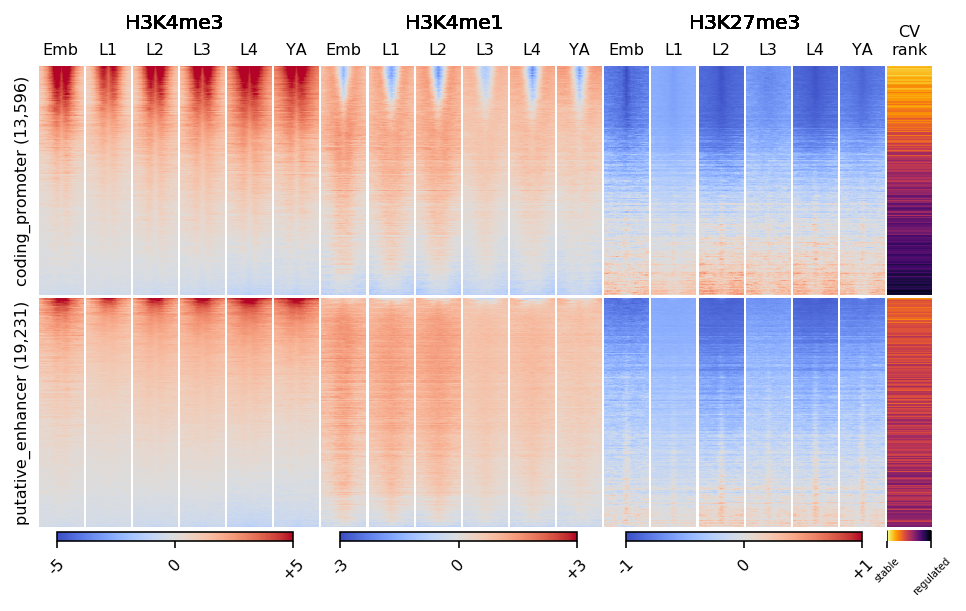

In [8]:
# plot
row_labels_ = [
    'coding_promoter (%s)' % (yp.f_uk(len(gdf.r.query('(annot == "coding_promoter")'))),), 
    'putative_enhancer (%s)' % (yp.f_uk(len(gdf.r.query('(annot == "putative_enhancer")'))),),
]

cb = gdf.query('((annot == "coding_promoter") | (annot == "putative_enhancer"))')\
.sort(['annot']).sort(['H3K4me3_mean_mean'], ascending=False)\
.imshow(
    figsize=(8, 4),
    savefig=False,
    kwargs_grid = {'cbar_size': '5%', 'cbar_pad': 0.02, 'axes_pad': 0.02,},
    axis_off=True,
    cluster_col='annot',
    nsquashed=200,
    vextent=1,
    suptitle='',
    row_labels=row_labels_,
    fontsize=8,
    figB_magic=True,
    l_title_cbar=['H3K4me3\nwt_emb', 'H3K4me1\nwt_emb', 'H3K27me3\nwt_emb','CV\nrank'],
)

fp_ = 'annot_Apr27/Fig3A_HMsortbyH3K4me3.png'
plt.savefig(fp_, dpi=600, transparent=True, bbox_inches='tight')